Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", 
as well as your name(s) and group number in the cell below:

In [160]:
NAMES = "Savinjith Walisadeera, Adam Herbertsson, Tobias Riedel"                # fill in your name(s) between the quotes, comma separated if more than one
GROUP = "47"                                                                    # fill in your group number between the quotes

---

# Interpolation and Approximation

In this assignment we start by looking at interpolation:

* We will look at interpolation of $x, y$ data via polynomials, using different approaches. 
* We will make sure that we get the same polynomial in all cases.
* We will also take a quick look at cublic spline interpolation of the same data and compare the results.

Second, we will learn about properties of the Fourier transform, a very powerful technique to find frequencies (periodicities) in data. We can use the DFT (discrete Fourier transform) to go back and forth between data in the time (or spatial) and frequency domain.

Finally, we will look at fitting a non-linear function to experimental data. 
Remember that we did fitting of linear models in an earlier assignment. 
In the case of a linear model the coefficients were calculated by solving a system of linear equations. 
In the non-linear case one needs to use an iterative procedure in order to find the coefficients.

We start as usual by importing the necessary modules

In [161]:
# just run this cell

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

C:\Users\savin\AppData\Local\Temp\ipykernel_24684\3559789937.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Let's create a very small data set. These are the same data that we will be using in the lecture, where we will do the interpolation by hand on the blackboard. In this assignment we will program the various methods for the general case and then test our code on this small example.

In [162]:
# just run this cell

x = np.array([0, 2/3, 1])
y = np.array([1, 0.5, 0])

Let's have a quick look at our data.

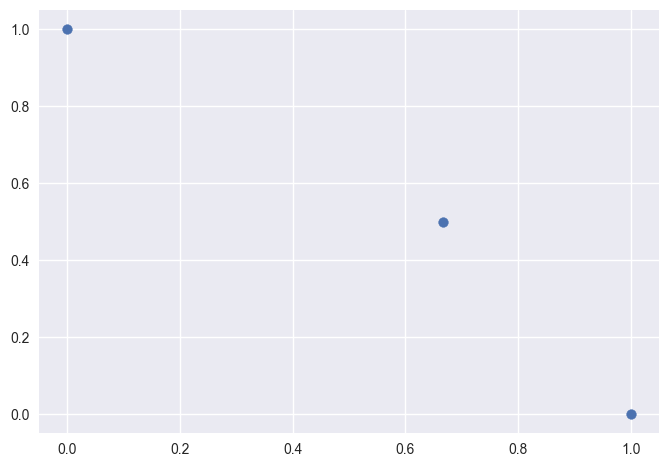

In [163]:
# just run this cell

plt.scatter(x, y)
plt.show()

## Problem 1 - Interpolation

### Problem 1.1

#### Monomials, Vandermonde matrix

Write a function `vandermonde` which takes a vector of data points $x$ and from that constructs  the **Vandermonde** matrix $V$

$$V = \begin{pmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^{n-1}\\
1 & x_1 & x_1^2 & \ldots & x_1^{n-1}\\
1 & x_2 & x_2^2 & \ldots & x_2^{n-1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n-1} & x_{n-1}^2 & \ldots & x_{n-1}^{n-1} \\
\end{pmatrix}$$

Each column of the Vandermonde matrix contains a *monomial* (i.e a polynomial with only one order) of $x$.

Note that you will need to find $n$, which is the length of the vector $x$ (with elements $x_i$, where $i=0\ldots n-1$).

Hint: Note that each column is $x$-times the column on its left. So I suggest you initialize the matrix to be a $n \times n$ matrix with all ones 
(let's call it `V`, and then loop over columns $j= 1\ldots n-1$ and set the $j$-th column of `V` to $x$ times the $j-1$-th column of `V`.

In [164]:
def vandermonde(x):
  n = len(x)
  V = np.ones((n, n))
  for i in range(1, n):
      V[:,i] = x**i
  return V

# now call our function with our test vector
V = vandermonde(x)
V

array([[1.        , 0.        , 0.        ],
       [1.        , 0.66666667, 0.44444444],
       [1.        , 1.        , 1.        ]])

We can make sure that our function works by comparing it with `numpy`s version. 
Note, that `np.vander` has the columns in the opposite order, 
unless we call it with the parameter `increasing=True` the default is `False`.

In [165]:
assert (V == np.vander(x, increasing=True)).all()

Now solve the system of equations

$$V \vec{c} = \vec{y}$$

and turn the coefficients $c$ (a vector of length $n$ which in our case is $n=3$) into a `poly1d` object. Note that a `poly1d` has the coefficients stored in descending order of $x$, so for example 

``` python
a = np.poly1d([2, 1, -1])
```

corresponds to the polynomial 

$$ p(x) = (2)x^2 + (1)x^1 + (-1) x^0 = 2x^2 +x -1 $$

So you will have to either flip the matrix around before solving the system of equations, or turn the solution vector around before calling `np.poly1d()` on it.

Print the resulting polynomial. Note, using `print(p)` will try and print a pretty version of the polynomial showing the various powers of x and their coefficients. 

You can get just the coefficients by using `print(p.coefficients)`. 

Finally, just using `p` as the last statement of the cell will reproduce the statement that generates the polynomial.

In [166]:
# solve the system of equations and call the solution vector c
# c = ...
# create a poly1d object from that solution and call it p
# p = np.poly1d(...)

# YOUR CODE HERE
c = np.linalg.solve(V, y)
p = np.poly1d(np.flip(c))


print(p)
print(p.coefficients)
p

       2
-0.75 x - 0.25 x + 1
[-0.75 -0.25  1.  ]


poly1d([-0.75, -0.25,  1.  ])

Because we now have our solution in the form of a `poly1d` object, we can very easily evaluate that polynomial on a new vector.

In [167]:
# just run this cell

t = np.linspace(0, 1)     # we are using linspace's default of 50 points
zp = p(t)

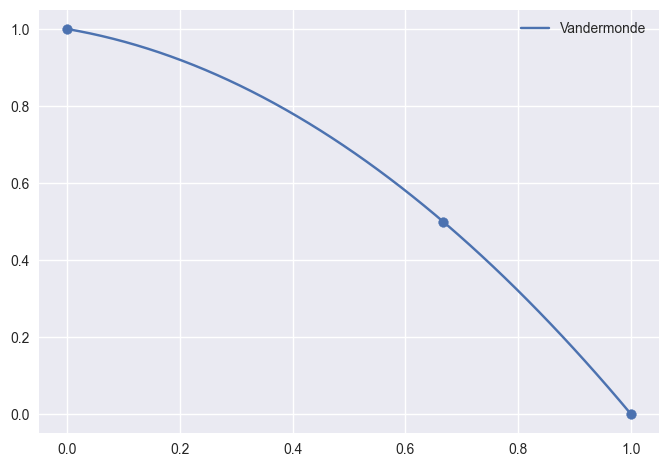

In [168]:
# just run this cell
# start by showing the original data again
plt.scatter(x, y)
# now plot the interpolating data
plt.plot(t, zp, label='Vandermonde')
plt.legend()
plt.show()

### Problem 1.2 

#### Lagrange polynomials

The *cardinal* or *Lagrangian* polynomial is defined as

$$L_k(x) = \prod_{i=0, i\ne k}^{n-1} \frac{x - x_i}{x_k - x_i}$$

which has the property

$$L_k(x_j) = \delta_{kj} = \left\{\begin{array}{ll}
1 & k = j \\
0 & k \ne j\end{array}\right.$$

which allows us to construct an interpolating polynomial as follows

$$p(x) = \sum_{i=0}^{n-1} y_i L_i(x)$$

Write a function `Lagrange` that takes two vectors, $x$ and $y$, and generates the polynomial $p(x)$ by looping over $x$ and $y$. You will have to use an inner loop to build up $L_i(x)$ and an outer loop which sums up $y_i L_i(x)$. 

Note that you will need to initialize the sum with `np.poly1d(0.0)` and initialize the products $L_i(x)$ with `np.poly1d(1.0)`, in order that you can iterate over terms that you want to add or multiply onto them.

Make use of the fact that the factors $\frac{x - x_j}{x_i - x_j}$ appearing in $L(x)$ can be represented in Python using numpy's `poly1d` objects like this

``` python
p = np.poly1d([1.0, -x[j]])/(x[i]-x[j])
```

In [169]:
def Lagrange(x, y):
  n = len(x)
  p = np.poly1d(0) # Final polynomial, initial as 0 because addition is used in loop

  # Sum loop
  for i in range(0, n):
    Li = np.poly1d(1) # Li(x) polynomial, initial as 1 because multiplication is used in loop
    # Li(x) build loop
    for j in range(0, n):
      if i == j:
        continue
      Li *= np.poly1d([1.0, -x[j]])/(x[i]-x[j])

    p += y[i]*Li

  return p
      

# use it on our test case
q = Lagrange(x, y)
q

poly1d([-0.75, -0.25,  1.  ])

Let's compare the polynomial $p$ from problem 1.1 and polynomial $q$ from problem 1.2. Obviously, we want the result to be the same, within machine precision.

In [170]:
# just run this cell, but this assumes you calcutated q in the previous cell!

t = np.linspace(0, 1)
zq = q(t)

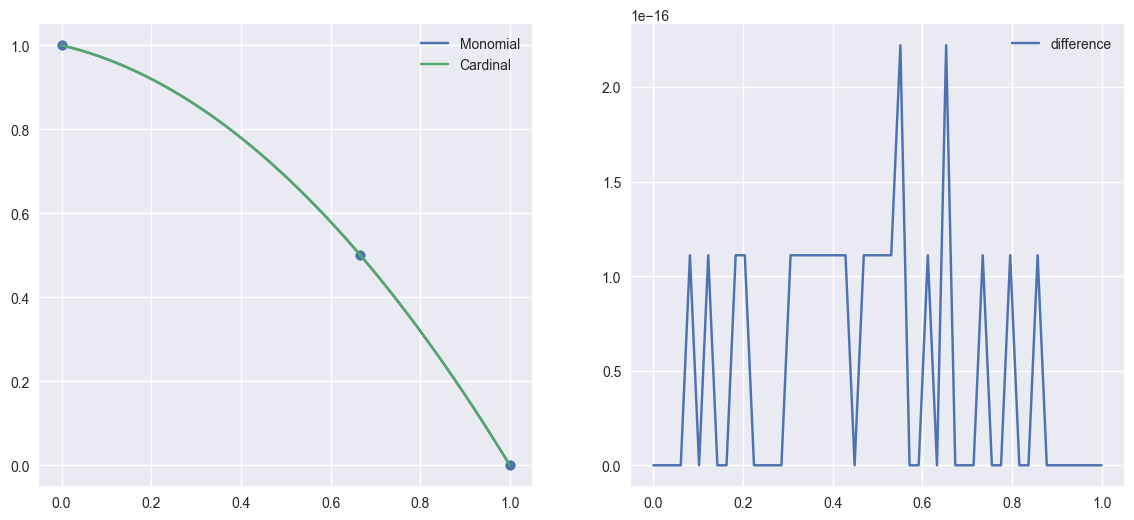

array([-3.33066907e-16,  3.33066907e-16,  0.00000000e+00])

In [171]:
# just run this cell

fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].scatter(x, y)
axs[0].plot(t, zp, label='Monomial')
axs[0].plot(t, zq, label='Cardinal')
axs[0].legend()

axs[1].plot(t, zp-zq, label='difference')
axs[1].legend()
plt.show()
p.coefficients - q.coefficients

In [172]:
assert(np.sqrt(np.sum((p.coefficients - q.coefficients)**2)) < np.finfo(float).resolution)

### Problem 1.3

#### The Newton interpolation polynomial

$$\begin{eqnarray}
p_0(x) & = & c_0 \\
p_1(x) & = & c_0 + c_1 (x-x_0) \\
p_2(x) & = & c_0 + c_1 (x-x_0) + c_2 (x-x_0)(x-x_1) \\
& \vdots & \\
p_n(x) & = & c_0 + c_1 (x-x_0) + c_2 (x-x_0)(x-x_1) + \ldots + c_n (x-x_0)(x-x_1) \ldots (x-x_{n-1})
\end{eqnarray}$$

Again, we want that

$$p_n(x_i) = y_i$$

It is clear that 
$$c_0 = y_0 \quad {\rm and} \quad c_1 = \frac{y_1 - y_0}{x_1 - x_0}$$

and by recursion

$$p_k(x) = p_{k-1}(x) + c_k \prod_{i=0}^{k-1} (x-x_i) \quad {\rm where} \quad c_k = \frac{y_k-p_{k-1}(x_k)}{\prod_{i=0}^{k-1} (x_k-x_i)} \quad {\rm for} \quad 1 \le k \le n$$

Write a function `Newton` which calculates the polynomial by recursion.

---


* start by initializing $c_0$ and $p_0(x)$ (which is `np.poly1d(y[0])`)
* when calculating the next $c_k$, the product in the denominator can be done with one `numpy` statement, but using a loop is also fine, of course.
* you won't have to store all components of $c$ in a vector, at each step in the recursion you only need one single element and you may use the same variable for that every time if you want.
* also note, that at each iteration, the product appearing in the formula for $p_k(x)$ grows by one factor $(x-x_{k-1})$, so no need to re-calculate the whole product at each step.

In [173]:
def Newton(x, y):
  n = len(x)
  p = np.poly1d(y[0])
  
  # Polynomial loop
  for k in range(1, n):
    ck = (y[k]-p(x[k]))/(x[k]-x[:k]).prod()
    # Calculate product to multiply with ck
    pp = np.poly1d(1)
    for i in range(0, k):
      pp *= np.poly1d([1, -x[i]])

    p += ck*pp

  return p


# use it on our test case                 
r = Newton(x, y)
r          

poly1d([-0.75, -0.25,  1.  ])

Again, let's compare with the polynomial from problem 1.1.

In [174]:
t = np.linspace(0, 1)
zr = r(t)

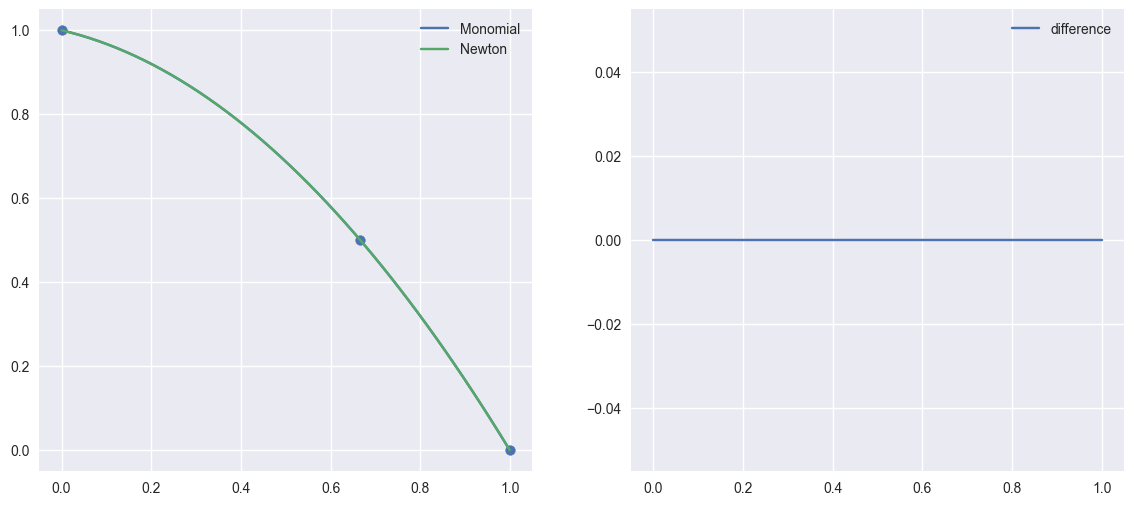

In [175]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].scatter(x, y)
axs[0].plot(t, zp, label='Monomial')
axs[0].plot(t, zr, label='Newton')
axs[0].legend()

axs[1].plot(t, zp-zr, label='difference')
axs[1].legend()
plt.show()

In [176]:
assert(np.sqrt(np.sum((p.coefficients - r.coefficients)**2)) < np.finfo(float).resolution)

### Cubic splines

Let's quickly look at interpolation by cubic splines. Nothing to do for you, except to run the cells and notice the difference in the performance when compared with the interpolating polynomial.

In [177]:
# just run this cell
from scipy.interpolate import CubicSpline

In [178]:
# just run this cell
f = CubicSpline(x, y, bc_type='natural')
t = np.linspace(0, 1)
zf = f(t)

### Problem 1.4

Produce the same kind of plots as in problem 1.2 and 1.3, but now compare values `zp` (the vector you got when you evaluated your polynomial based on the Vandermonde matrix) and `zf` from the previous cell.

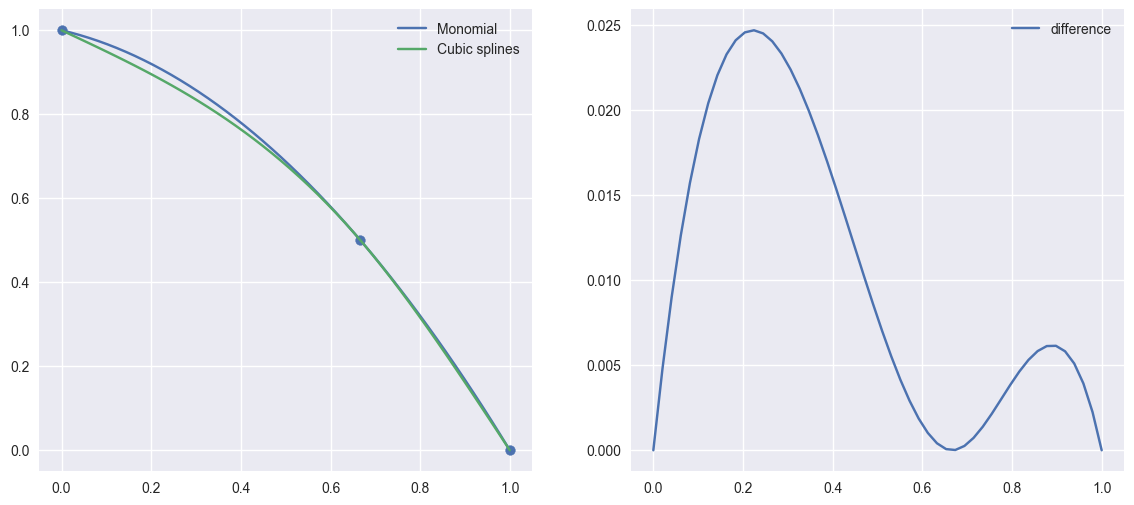

In [179]:
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].scatter(x, y)
axs[0].plot(t, zp, label='Monomial')
axs[0].plot(t, zf, label='Cubic splines')
axs[0].legend()

axs[1].plot(t, zp-zf, label='difference')
axs[1].legend()
plt.show()

### Problem 1.5

Use any of your polynomial methods from above (**but not the cubic splines!**) to solve the following mathematical puzzle:

A water fountain of height $h$ is spraying water along a perfect parabola (see figure). The parabola has its vertex at a height of 3 meter and 1 meter away from the fountain. The water hits ground after another 2 meter to the right.

* Construct the quadratic polynomial that fits the path of the water and then use that polynomial to solve for the height $h$ in meter of the fountain.
* Store your solution in a variable called `h`.

![bitmap.png](attachment:bitmap.png)

In [180]:
p = Newton(np.array([-1, 1, 3]), np.array([0, 3, 0])) # (-1, 0) -> from symmetry of porabola
h = p(0)

In [181]:
# If you have done everyting correctly, the following test should pass

assert h == 2.25

## Problem 2 - Fourier transform

The discrete Fourier transform of a set of data helps to find periodic components in the data vector.
The data vector in its most general form consists of complex components. 

A set of data $y_m, m = 0\ldots N-1$ is represented by its (discrete) Fourier transform

$$Y_k = \sum_{m=0}^{N-1} y_m \exp \left(-2\pi i \frac{mk}{N}\right) = 
\sum_{m=0}^{N-1} y_m \left[\cos \left(-2\pi \frac{mk}{N}\right)
+ i \sin \left(-2\pi \frac{mk}{N}\right)\right]$$

Note, that $i$ here is the imaginary unit, not an index!

The inverse transform is

$$y_m = \frac{1}{N} \sum_{k=0}^{N-1} Y_k \exp \left(2\pi i \frac{mk}{N}\right)$$

The ususal implementation of the discrete Fourier transform has 
* the zero-frequency term in $Y_0$, 
* the components $Y_1\ldots Y_{N/2-1}$ contain the positive frequencies 
* and $Y_{N/2}\ldots Y_{N-1}$ contain the negative frequencies in descending order!

The discrete Fourier transform is most efficiently calculated when $N$ is a power of 2.

In `numpy` discrete Fourier transform is done via `np.fft.fft` (i.e function `fft` in submodule `fft` of
module `numpy`, which we import as `np`). The inverse transform is `np.fft.ifft`.

Note the asymmetry in form of the factor $\frac{1}{N}$ in the two transforms.

### Problem 2.1

Construct a vector $y$ of random complex numbers of length $N=16$, where both the real part and the imaginary part are normally distributed with zero mean and variance 1. 
You will need two calls of `np.random.randn` for the real and imaginary parts and combine them to form $N$ random complex numbers.

In [182]:
N = 16
# YOUR CODE HERE

re = np.random.randn(N)
img = np.random.randn(N)

y = re + img * 1j

print(y)

[-2.44830998-0.66655746j -0.54979419+0.61071665j -1.32597868+0.33322622j
 -0.77585591-0.46220494j  0.2472966 +0.8829954j   0.35930453-0.32561792j
 -1.4415651 -0.94919648j  1.54944776+0.34564384j -1.19139694-0.78215803j
  0.44848987+1.77319086j -0.62469262+0.58779658j -1.22317016+0.90187687j
 -1.64881179+0.19107728j  1.29672068-2.23834322j  0.40931634-0.72001015j
  0.47770382+1.90016018j]


Parseval's theorem states that the total power (the sum over all components squared) is preserved under the Fourier transformation. Note, however, that because the factor $\frac{1}{N}$ is applied when doing the inverse transform and not the direct transform, the discrete Fourier transform of our vector $y$ will be off by $\sqrt{N}$ and therefore the squares of the components by $N$. This is corrected for in the code in the cell below. 

In the case of complex values we calculate the total power as 

$$ \sum_{m=0}^{N-1} y_m \overline{y_m}$$

where $\overline{y_m}$ is the complex conjugate of $y_m$ (hint: use `np.conj()`).

### Problem 2.2

In the function below, fill in the code to calculate the total power for a complex vector $x$, 
and add the code to perform the Fourier transform of `y` and the inverse Fourier transform of `Y`. 

In [183]:
import numpy as np

# Total power code
def total_power(x):
    total_pwr = np.sum(x*np.conj(x))
    return total_pwr

# Fourier transformation

print(total_power(y))

(38.76725872151639+0j)


In [184]:
np.sum(x*np.conj(x))

1.4444444444444444

In [185]:
# YOUR CODE HERE
def parseval(y):
    """Function to demonstrate Parseval's theorem, which states that the 'total power'
    is preserved during a Fourier transform.

    By 'total power' we mean the sum over all v_i*conj(v_i), given a vector v.
    """

    # calculate the discrete Fourier transform of y
    Y = np.fft.fft(y)
    #Y = np.fft.ifft(y)
# YOUR CODE HERE
    # calculate the total power of the input vector y and of its Fourier transform Y, using your function 
    p1 = total_power(y)
    p2 = total_power(Y)
    # now do the inverse Fourier transform of Y and check that you get the original vector y back.
    z = np.fft.ifft(Y)

    print('y:', y)
    print('z:', z)
# YOUR CODE HERE
    # calculate the difference of z and y
    d = z-y 
    print(p1, p2/N)
    
    print(f"power in time series: {p1:8.3f}")
    print(f"power in freq series: {p2/N:8.3f}")
    # print(f"power in difference: {pd:8.3f}")
    
    return p1, p2, d

p1, p2, d = parseval(y)

y: [-2.44830998-0.66655746j -0.54979419+0.61071665j -1.32597868+0.33322622j
 -0.77585591-0.46220494j  0.2472966 +0.8829954j   0.35930453-0.32561792j
 -1.4415651 -0.94919648j  1.54944776+0.34564384j -1.19139694-0.78215803j
  0.44848987+1.77319086j -0.62469262+0.58779658j -1.22317016+0.90187687j
 -1.64881179+0.19107728j  1.29672068-2.23834322j  0.40931634-0.72001015j
  0.47770382+1.90016018j]
z: [-2.44830998-0.66655746j -0.54979419+0.61071665j -1.32597868+0.33322622j
 -0.77585591-0.46220494j  0.2472966 +0.8829954j   0.35930453-0.32561792j
 -1.4415651 -0.94919648j  1.54944776+0.34564384j -1.19139694-0.78215803j
  0.44848987+1.77319086j -0.62469262+0.58779658j -1.22317016+0.90187687j
 -1.64881179+0.19107728j  1.29672068-2.23834322j  0.40931634-0.72001015j
  0.47770382+1.90016018j]
(38.76725872151639+0j) (38.76725872151639+0j)
power in time series: 38.767+0.000j
power in freq series: 38.767+0.000j


In [186]:
# if everything is correct the following tests should pass

# the powers returned should have zero imaginary part
assert np.imag(p1) == 0.0
assert np.imag(p2) == 0.0

# the two powers should be equal (within machine accuracy)
assert np.abs(p1 - p2/N) < N*np.finfo(float).resolution

# the difference between the original data and the (forward and back) transformed data should be negligible
assert (np.abs(d) < np.finfo(float).resolution).all()

Let's create a copy of our vector $y$, where we set all imaginary parts to zero. We still want the vector to be of type complex.

In [187]:
yr = y.copy()
yr.imag = 0.0
print(yr)
print(yr.dtype)

[-2.44830998+0.j -0.54979419+0.j -1.32597868+0.j -0.77585591+0.j
  0.2472966 +0.j  0.35930453+0.j -1.4415651 +0.j  1.54944776+0.j
 -1.19139694+0.j  0.44848987+0.j -0.62469262+0.j -1.22317016+0.j
 -1.64881179+0.j  1.29672068+0.j  0.40931634+0.j  0.47770382+0.j]
complex128


### Problem 2.3

Calculate the Fourier transform of `yr` and plot the real part and the imaginary part of the result in two different subplots. Use `np.arange(N)` as the $x$-values of those plots. Draw a vertical, red line at $x = N/2$ in both subplots. What do you observe? 

<function matplotlib.pyplot.show(close=None, block=None)>

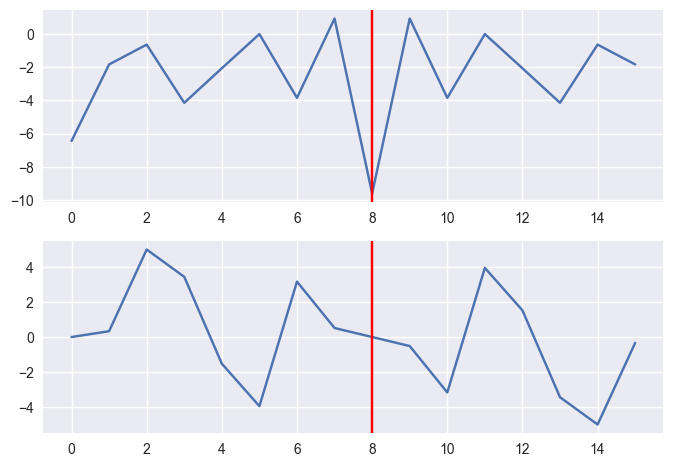

In [188]:
x = np.arange(N)
fig, axs = plt.subplots(2,1)

# Yr = ....   Fourier transform of yr
# plot real part of Yr on axs[0], imaginary part on axs[1]
# draw a vertical, red line at x = N/2 in both plots

# YOUR CODE HERE
Yr = np.fft.fft(yr)
plt1 = np.real(Yr)
plt2 = np.imag(Yr)

axs[0].plot(x, plt1)
axs[1].plot(x, plt2)
axs[0].axvline(N/2, color='red')
axs[1].axvline(N/2, color='red')
plt.show

YOUR ANSWER HERE

The following cell contains the code for function `plot_Fourier_pair`.
It takes a float vector `amp` of length three (containing $a_0, a_1, a_2$), 
and an integer vector `n` of length two (containing $n_0, n_1$)
and plots the function

$$y_j = f(x_j) = a_0 + a_1 \cos(n_0 x_j) - a_2 \cos(n_1 x_j)$$

where the $a_i, i=0, 1, 2$ are the amplitudes and $n_i, i=0, 1$ are the frequencies.
and where $x_j = 2\pi j/N, j = 0\ldots N/2-1$.

The function then makes a "symmetric" version of vector $y$ by constructing

$$y_{sym} = (y_0, y_1, \ldots , y_{N/2-3}, y_{N/2-1}, 0, y_{N/2-1}, y_{N/2-3}, \ldots , y_2, y_1)$$

which will assure that the FFT (Fast Fourier Transform) of our
vector $y_{sym}$ also will be **"symmetric" and real** valued.

In [189]:
# just run this cell

# The length of our Fourier transform, FFTs work best with powers of 2.
N = 128

def plot_Fourier_pair(amp, n):
    """Given 3 amplitudes and 2 frequencies, the routine plots the function

    amp[0] + 0.5*np.random.randn(len(x)) + amp[1]*np.cos(n[0]*x) - amp[2]*np.cos(n[1]*x)

    and then shows the discrete Fourier transform of this function in
    a second panel.  The function is extended into a symmetric form
    first, such that the Fourier transform is real valued.
    """

    j = np.arange(N//2)
    x = 2*np.pi*j/N

    y = amp[0] + 0.5*np.random.randn(len(x)) + amp[1]*np.cos(n[0]*x) - amp[2]*np.cos(n[1]*x)
    y_sym = np.concatenate((y, np.zeros(1), np.flip(y[1:])))
    Y = np.fft.ifft(y_sym)

    fig, axs = plt.subplots(2,1, figsize=(16,8))

    i = np.arange(N)
    # axs[0].plot(i, y_sym)
    axs[0].plot(i, y_sym)
    axs[0].plot(j, y)
    axs[0].set_title(f"{amp[0]:.1f} + {amp[1]:.1f}*cos({n[0]}*x) - {amp[2]:.1f}*cos({n[1]}*x) + noise",
                    fontsize=20)
    # axs[0].grid()

    axs[1].plot(i, np.real(Y))
    # axs[1].grid()

    plt.show()


Play around with function `plot_Fourier_pair`. Observe how the three
amplitudes and the two frequencies show up in the Fourier transform
of our signal.

Just execute the following cell a couple of time 
(hint: use Ctrl-Return for that in order not to advance to the next cell.

Every time the function will be called with three random amplitudes and two random frequencies.
These numbers are shown in the title of the upper panel, which shows the symmetric version of our vector $y$, 
with the index $j$ on the $x$-axis.

Observe how these numbers affect the Fourier transform shown in the
lower panel. After a while you should be able to predict what the
Fourier transform will look like given the input amplitudes and
frequencies.

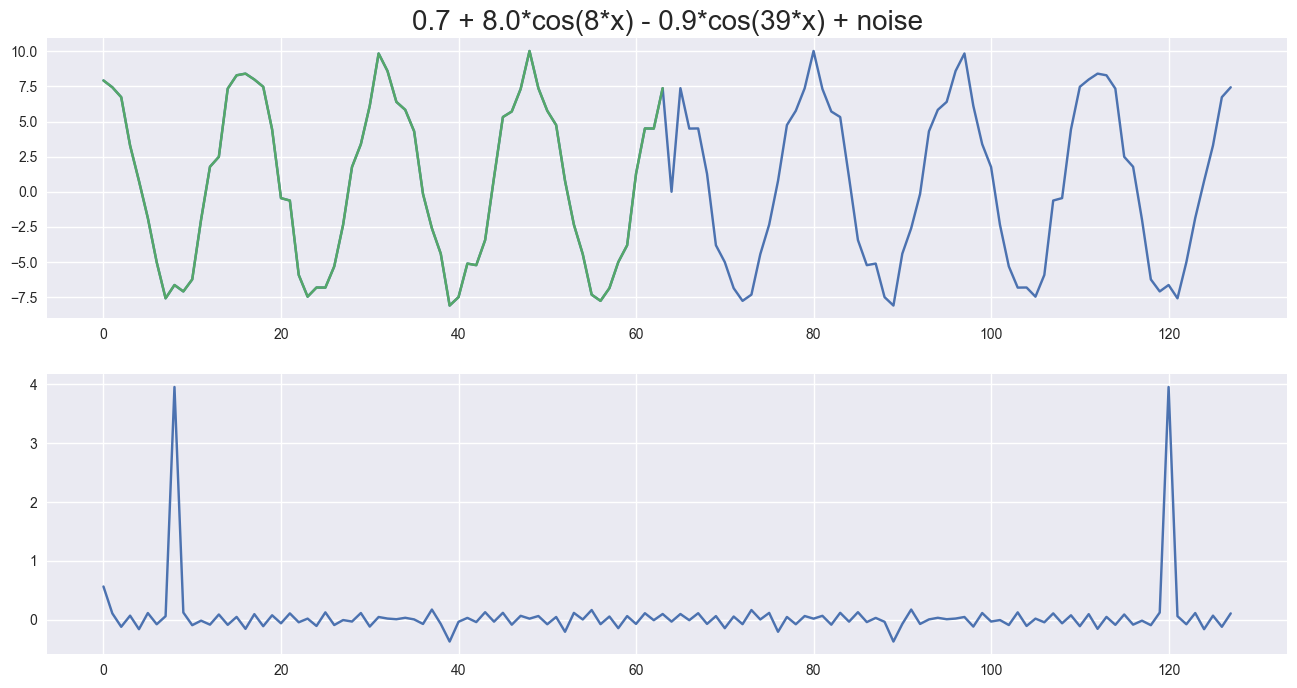

In [192]:
# generate three random amplitudes in the range 0...10.0
amp = 10.0*np.random.rand(6)
# generate two random (integer) frequencies in the range 2...N/2-2. 
n = np.random.randint(2, N//2-2, 2)
plot_Fourier_pair(amp, n)

Can you read off by eye which amplitudes and which frequencies
generated the following plot? Confirm, by calling function
`plot_Fourier_pair` with your guesses and make sure it agrees with
the shown plot.

![fft.png](attachment:fft.png)


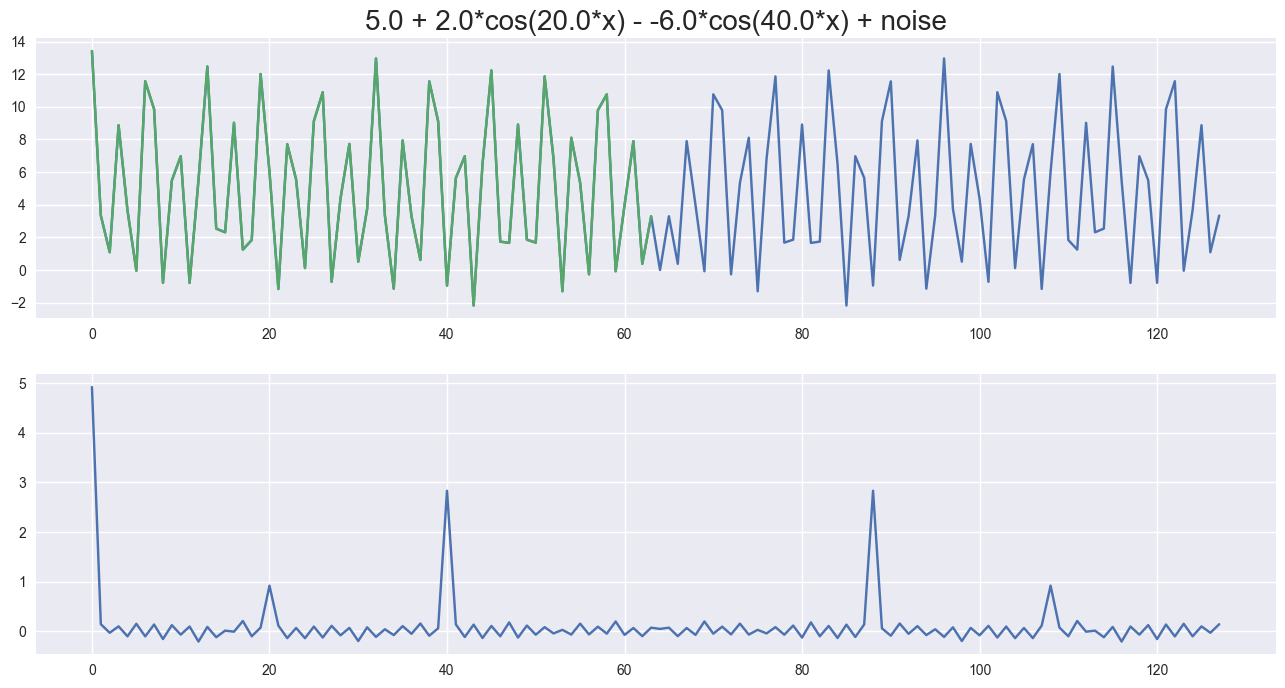

In [193]:
# amp = [..., ..., ...]  # fill in your guesses
# n = [..., ...]         # fill in your guesses

# YOUR CODE HERE
amp = [5.0, 2.0, -6.0]
n = [20.0, 40.0]
# now make sure that you get the above plot in the lower panel
plot_Fourier_pair(amp, n)

## Problem 3 - Non-linear fitting

In the rest of the assignment, we look at the problem of fitting a non-linear function to a set of experimental data. Our use-case is fitting the profile of a radio astronomical spectrum to data observed with the Onsala 20m radio telescope. The profile describes how an observed spectral line of the molecule HCN might look like, when we point the radio telescope towards a molecular cloud containing this substance. 

In the next cell we define our model. It takes four parameters:

- `amp` an amplitude, i.e. scaling of our profile, which in reality would be related to the temperature of the molecular cloud we are observing
- `v0`  a velocity shift, which would describe if the cloud is moving away or towards us
- `w`  the width at half maximum of the spectral line, which characterizes the turbulence in the cloud
- `tau0` the overall *optical depth* (typically designated $\tau$), which is a measure of how many molecules are in the beam of our radio telescope.

The profile of HCN shows three components, each described by a Gaussian profile. 
Their relative statistical weights and distance from each other are fixed (they are constants of this particular substance) and they are defined in variables `velocities` and `strengths`.

> There is no need for you to understand why the function looks as it does, 
> just accept that it represents a highly non-linear function operating on an input vector 
> and is based on four parameters.
> I will discuss it briefly in my second lecture on this topic, 
> but also have a look at the bonus problem if you are curious.

In [ ]:
from scipy.optimize import curve_fit

G = np.sqrt(4.0*np.log(2.0))  # a constant to normalize the individual Gaussian profiles

def profile(X, amp, v0, w, tau0):
    velocities = np.array([3.981, -0.796, -7.962])
    strengths  = np.array([0.333,  0.555,  0.111])
    # uncomment the following line if you want to 
    # print(f"amp={amp:.4f}, v0={v0:.4f}, w={w:.4f}, tau0={tau0:.4f}")

    s0 = np.zeros(X.shape)
    for i, v in enumerate(velocities):
        arg = G*(X-v0-v)/w
        s0 += strengths[i]*np.exp(-arg*arg)
    tau = tau0*s0
    P = amp*(1.0-np.exp(-tau))
    return P

Let's create a vector of velocities from -15 to +15, and call our profile function with parameters 
- `amp = 11.0`
- `v0 = 0.5`
- `w = 2.3`
- `tau0 = 0.8` 

Note, how we can pass all four parameters as `*params`, rather than passing four individual values. 
A Python function will automatically unpack an array which is passed with an asterisk in front of its name, 
here `*params`. 

We also add some random noise to our profile, and plot it using the `plt.step` function, which nicely represents the various channels of our spectrometer.

Feel free to play around with the parameters, maybe change each of them one at a time, to see what effect it has on the spectrum. Make sure you restore to

```python
params = [11.0, 0.5, 2.3, 0.8]
```
when you are done your exploration.

parameters: [11.0, 0.5, 2.3, 0.8]


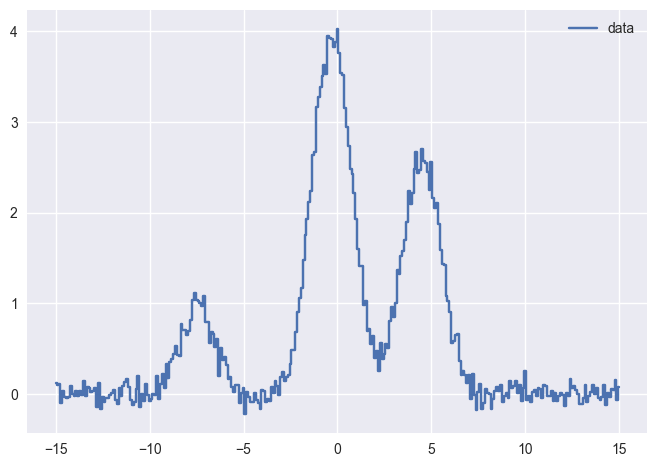

In [ ]:
# just run this cell

V = np.linspace(-15.0, 15.0, 301)
params = [11.0, 0.5, 2.3, 0.8]
print("parameters:", params)
sigma = 0.1  # noise level
S = profile(V, *params) + sigma*np.random.randn(len(V))

plt.step(V, S, where='mid', label="data")
plt.legend()
plt.show()

Now, let's pretend we don't know the parameters which generated this plot. But we can take a guess and calculate a profile `Y0` based on that guess.

[30.0, 0.0, 0.2, 0.1]


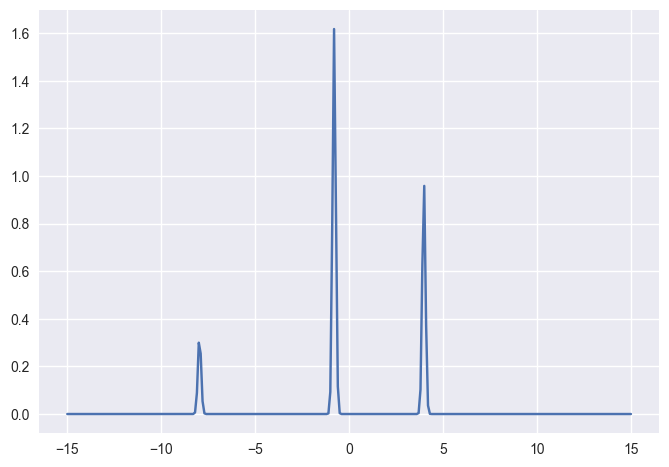

In [ ]:
# just execute this cell
guess = [30.0, 0.0, 0.2, 0.1]
print(guess)
Y0 = profile(V, *guess)
plt.plot(V, Y0)
plt.show()

Use function `curve_fit` from the `scipy` package, which we imported above, to find the optimum parameters that fit our data. The function returns the fitted parameters in variable `popt` (a vector) and the covariance matrix, describing the errors of the fitted values as well as how much they correlate with each other, in variable `pcov` (a matrix). 

> The function `curve_fit` takes the model function we want to fit, 
> two data vectors for the x- and y-data, respectively,  
> and an initial guess for the parameters.

In [ ]:
# just execute this cell
#
# you may want to uncomment the print statement in function profile above, 
# in order to see how often it gets called and how the solution converges.

popt, pcov = curve_fit(profile, V, S, p0=guess)
print(popt)
fit = profile(V, *popt)

[9.83055587 0.50723226 2.30811634 0.92012219]


Let's look at the guessed profile and the final, fitted one.

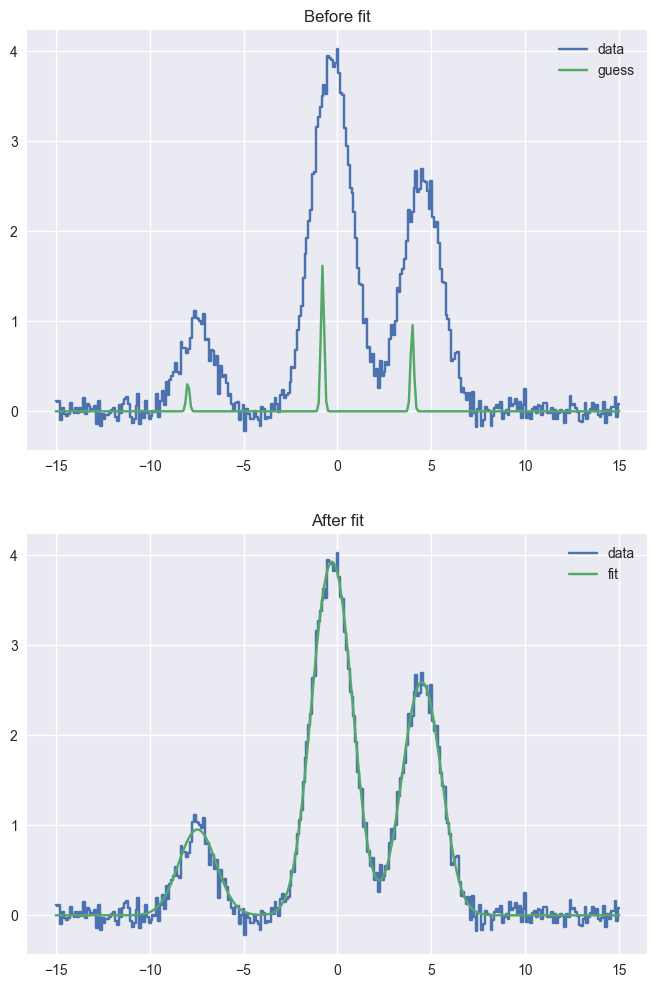

In [ ]:
# just run this cell

fig, axs = plt.subplots(2, 1, figsize=(8, 12))
axs[0].step(V, S, where='mid', label="data")
axs[0].plot(V, Y0, label="guess")
axs[0].legend()
axs[0].set_title("Before fit")

# axs[1].plot(V, S, label="data")
axs[1].step(V, S, where='mid', label="data")
axs[1].plot(V, fit, label='fit')
axs[1].legend()
axs[1].set_title("After fit")
plt.show()

### Problem 3.1

Calculate the RSS (residual sum of squares) for both the guessed profile and the fitted one.

$$RSS = \sum_{i=0}^{N-1} (y_i - p(v_i))^2$$

In our case $y$ is our data vector `S`, and $p(v)$ is `Y0` for our guessed profile and `fit` for the fitted profile.

In [ ]:
RSS_guess = ((S-Y0)**2).sum()
RSS_fit = ((S-fit)**2).sum()

print(f"residual sum of squares for guessed profile: {RSS_guess:8.3f}")
print(f"residual sum of squares for fitted  profile: {RSS_fit:8.3f}")

residual sum of squares for guessed profile:  408.965
residual sum of squares for fitted  profile:    2.657


### Problem 3.2

Plot the residual, i.e. plot `S-fit` as a function of velocity. Print the covariance matrix. 

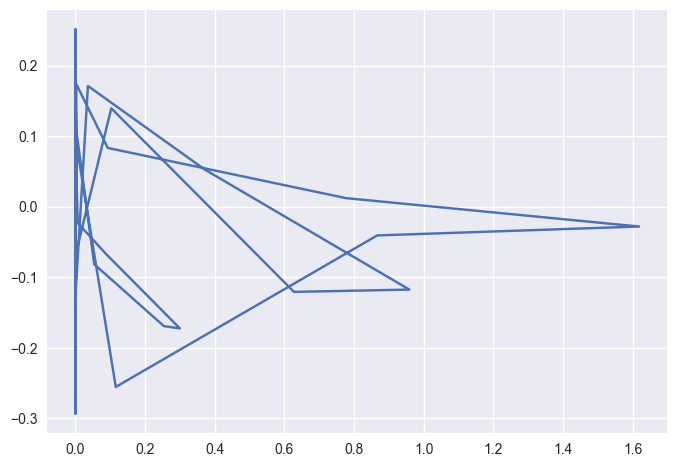

In [ ]:
plt.plot(Y0, S-fit)

### Problem 3.3

Which off-diagonal elements in the covariance matrix are the largest, i.e which of the four parameters are correlated the most?

Answer by writing something like: "amp" and "w"  (this is not the correct answer) 

YOUR ANSWER HERE

### Problem 3.4

Retrieve the estimated errors in our fitted parameters. You will need to extract the four diagonal elements of 
matrix `pcov` for that and take the square root of those. The errors will be in the same sequence as the parameters used by function `profile`, i.e error on `amp` first and `tau0` last. 
* Print the errors.
* Print the deviation in percent from the correct solution (which should still be in vector `params`). 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

### Problem 3.5

The following cell makes a scatter plot of the fitted parameters, as well as the correct solution.

* Add code to also plot error bars on the fitted values (hint: function `errorbar` in the `matplotlib` module.)
* label the x-axis with the names of the parameters, i.e. 'amp', 'v0', 'w' and 'tau0'

*Note, because the error bars will all be drawn on the same scale, not all of them may be big enough to be visible.*

In [ ]:
n = np.arange(4)
# plot error bars
# YOUR CODE HERE
raise NotImplementedError()
plt.scatter(n, popt, label="fitted")
plt.scatter(n, params, label="parameters")
plt.xticks(n)
# set tick labels on x-axis
# YOUR CODE HERE
raise NotImplementedError()
plt.legend()

### Bonus problem

By default, the `curve_fit` will calculate numerical derivatives of the profile function with respect to the parameters, in order to find the minimum in $\chi^2$. 
But it is also possible to pass it another function, one that will calculate the derivatives analytically. 

Just to be explicit, this is the analytical form of our profile function which we have been fitting:

$$p(v) = a (1-\exp(-\tau))$$

and where $\tau$ itself is a sum of three line components:

$$\tau = \tau_0 \sum_{i=0}^{2} s_i \exp\{-\left(G\frac{v-u_i-v_0}{w}\right)^2\}$$

Except for parameter $a$, the derivatives with respect to the parameter will be of the form

$$\begin{eqnarray}
\frac{\partial{p}}{\partial{\tau_0}} & = & \frac{\partial{p}}{\partial{\tau}} \frac{\partial{\tau}}{\partial{\tau_0}} \\
\frac{\partial{p}}{\partial{v_0}} & = & \frac{\partial{p}}{\partial{\tau}} \frac{\partial{\tau}}{\partial{v_0}} \\
\frac{\partial{p}}{\partial{w}} & = & \frac{\partial{p}}{\partial{\tau}} \frac{\partial{\tau}}{\partial{w}} \\
\end{eqnarray}$$

and therefore the inner derivatives ($\frac{\partial{\tau}}{\partial{\ldots}}$)
will also be sums over the three components. 
But they all have a common term $\frac{\partial{p}}{\partial{\tau}}$, which you can make use of in your code.

The mapping between the parameters above and variables in our code is as follows:
$a$ corresponds to variable `amp`, $v_0$ to `v0`, $w$ to `w` and $\tau_0$ to `tau0`.
The $s_i$ and $u_i$ are the molecular constants given in function `profile` as `strengths` and `velocities`.
$G = \sqrt{4 \ln 2}$ is a normalization constant, to make the integral over a Gaussian component equal to 1.

Write a function `derivative`, which returns a $N\times 4$ matrix $D$, where column $i$ is a vector giving the  derivative of function `profile` with respect to the $i^{th}$ parameter. 

The function will look very much like `profile` and has the same signature (i.e. takes the same function parameters). I provide you with a skeleton below, fill in the missing pieces.

In [ ]:
G = np.sqrt(4.0*np.log(2.0))  # a constant to normalize the individual Gaussian profiles

def derivative(X, amp, v0, w, tau0):
    velocities = np.array([3.981, -0.796, -7.962])
    strengths = np.array([0.333,  0.555,  0.111])
    # print(f"amp={amp:.4f}, v0={v0:.4f}, w={w:.4f}, tau0={tau0:.4f}")

    s0 = np.zeros(X.shape)
    # initialize the matrix D we are going to return
    D = np.zeros((len(X), 4))
    # the follwoing vectors will add up contributions to d(profile)/d(v0) and d(profile)/d(w)
    # just as s0 sums up the profile itself
    d1 = np.zeros(X.shape)
    d2 = np.zeros(X.shape)
    for i, v in enumerate(velocities):
        arg = G*(X-v0-v)/w
        tmp = strengths[i]*np.exp(-arg*arg)
        s0 += tmp
        # d1 += ...
        # d2 += ...
        # YOUR CODE HERE
        raise NotImplementedError()
    tau = tau0*s0

    # the following can all be expressed in terms of amp, tau, d1, d2 and s0 from above
    # D[:, 0] = ...  final derivative with respect to amp 
    # D[:, 1] = ...  final derivative with respect to v0
    # D[:, 2] = ...  final derivative with respect to w
    # D[:, 3] = ...  final derivative with respect to tau0

    # YOUR CODE HERE
    raise NotImplementedError()
    return D

Test your solution. Run the next cell and see if you achieve convergence. Note, how we pass our function to calculate the derivatives as parameter `jac` (for "Jacobian").

In [ ]:
# just run this cell

popt, pcov = curve_fit(profile, V, S, p0=guess, jac=derivative)
print(popt)
fit = profile(V, *popt)

fig, axs = plt.subplots(2, 1, figsize=(8, 12))
axs[0].step(V, S, where='mid', label="data")
axs[0].plot(V, Y0, label="guess")
axs[0].legend()

# axs[1].plot(V, S, label="data")
axs[1].step(V, S, where='mid', label="data")
axs[1].plot(V, fit, label='fit')
axs[1].legend()
plt.show()